In [356]:
import spectrum
from matplotlib import pyplot as plt
%matplotlib inline

In [357]:
field = "COSMOSC"

In [884]:
from astropy.io import ascii
cat = ascii.read("../data/mmsf2outcube_{}_allifu.cat".format(field))
ii_pointsources = (cat["class2"] == "halo") #* cat["use_stack"]

In [885]:
np.sum(ii_pointsources)

319

In [886]:

cube_cache = {}
scube_cache = {}


for ifu in np.sort(np.unique(cat[ii_pointsources]["ifu"])):
    #ifu, id, x,y,z = ps["ifu"],ps["id"],ps["x_com"], ps["y_com"], ps["z_com"]
    c  = "../data/outcube_{field}_{ifu}.fits.gz".format(field=field,ifu=ifu)
    cs = "../data/sf2outcube_{field}_{ifu}.fits.gz".format(field=field,ifu=ifu)
    cube_cache[ifu]  = spectrum.readSpectrum(c)
    scube_cache[ifu] = spectrum.readSpectrum(cs)
    


1.985839800000122

In [509]:
cL = 299792.46

In [903]:

REDSHIFTSPACE = True
TRANSVERSEDISTANCE = True
from astropy.cosmology import WMAP9 as cosmo
d = 1.

c = cube_cache["025"]

xysize = 33
zsize = 31

xysize_new = 29
zsize_new = 27

stack = []

pointsources = cat[ii_pointsources]
pointsources.sort('flux')
pointsources = pointsources[::-1]

cb_use = {}

xxnew = np.arange(-xysize_new/2,xysize_new/2 ) + .5
yynew = np.arange(-xysize_new/2,xysize_new/2 ) + .5
if TRANSVERSEDISTANCE:
    xxnew = (np.arange(-xysize_new/2,xysize_new/2 ) + .5) * .5 * 8.
    yynew = (np.arange(-xysize_new/2,xysize_new/2 ) + .5) * .5 * 8.

zznew = np.arange(-zsize_new/2,zsize_new/2 ) + .5
if REDSHIFTSPACE:
    zznew = ((np.arange(-zsize_new/2,zsize_new/2 ) + .5) * c.step/1216. ) * cL

Z,Y,X = np.meshgrid(zznew, yynew, xxnew, indexing='ij')
l = list(zip(Z.flatten(), Y.flatten(), X.flatten()))


for i, ps in enumerate( pointsources[:] ):
    #try:
        ifu, id, x,y,z,use_stack= ps["ifu"],ps["id"],ps["x_com"], ps["y_com"], ps["z_com"], ps["use_stack"]
        xl,xh = int(np.round(x)) - int(xysize//2), int(np.round(x)) + int(xysize//2)
        yl,yh = int(np.round(y)) - int(xysize//2), int(np.round(y)) + int(xysize//2)
        zl,zh = int(np.round(z)) - int(zsize//2), int(np.round(z)) + int(zsize//2)

        c = cube_cache[ifu]
        sc = scube_cache[ifu]

        data = c.data[zl:zh,yl:yh,xl:xh]
        data[data == 0.] = np.nan
        
        sdata = sc.data[zl:zh,yl:yh,xl:xh]
        sdata[data == 0.] = np.nan

        zz = np.arange(zl-z,zh-z) 
        if REDSHIFTSPACE:
            zz = (np.arange(zl-z,zh-z) * c.step/1216. ) * cL
            
        yy = np.arange(yl-y,yh-y) 
        xx = np.arange(xl-x,xh-x)     
        if TRANSVERSEDISTANCE:
            redshift = ps["wl_com"]/1216. - 1.
            s = cosmo.kpc_proper_per_arcmin(redshift).to(units.kpc/units.arcsec).value
            yy = np.arange(yl-y,yh-y) * .5 * s
            xx = np.arange(xl-x,xh-x) * .5 * s
        
        if False:
            print("xx,yy,zz,data: ",xx.shape,yy.shape,zz.shape,data.shape)

            print("xx.min(), xx.max() = ", xx.min(),xx.max())
            print("yy.min(), yy.max() = ", yy.min(),yy.max())
            print("zz.min(), zz.max() = ", zz.min(),zz.max())

            print("xxnew.min(), xxnew.max() = ", xxnew.min(),xxnew.max())
            print("yynew.min(), yynew.max() = ", yynew.min(),yynew.max())
            print("zznew.min(), zznew.max() = ", zznew.min(),zznew.max())
    
        my_interpolating_function = RegularGridInterpolator((zz, yy, xx), data, bounds_error=False)

        idata = my_interpolating_function(l)

        idata = idata.reshape(X.shape)
        
        stack.append(idata)
        
        if False:
            
            plt.ioff()
            f = plt.figure(figsize=[5,3])
            plt.subplot(1,3,1)
            plt.imshow( np.sum(sdata, axis=0)) 
            
            plt.subplot(1,3,2)
            plt.imshow( np.sum(data, axis=0)) 

            plt.subplot(1,3,3)
            plt.imshow( np.sum(idata, axis=0)) 
            plt.show()
            
            print("PS @ ifu {} id {}".format(ifu,id))
            cb_use[ (ifu,id) ] = widgets.Checkbox(description='use', value=False)
            #cb_use[ (ifu,id) ].value = ps["use_stack"]
            canvas  = widgets.Output(layout=Layout(height='10px', width = '200px', border='light'))
            items = [canvas, cb_use[ (ifu,id) ]]
            hb1 = widgets.HBox(items, layout=Layout(width='100%', positioning="bottom"))

                
            display( hb1 )


stack = np.array(stack)   




ValueError: There are 32 points and 0 values in dimension 2

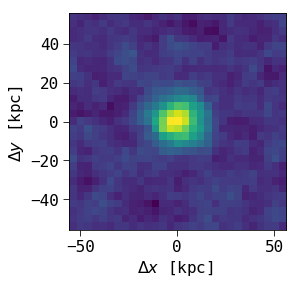

In [898]:
mstack = np.nanmedian(stack, axis=0)
extent = [ np.min( yynew) , np.max( yynew) , np.min(xxnew), np.max(xxnew) ] 

f = plt.figure()
plt.imshow( mstack[zsize_new//2], origin='bottom', extent=extent) 
plt.xlabel("x")
plt.ylabel("y")


if TRANSVERSEDISTANCE:
    plt.xlabel("$\Delta x$ [kpc] ")
    plt.ylabel("$\Delta y$ [kpc] ")
else:
    plt.xlabel("$\Delta x$ [\"] ")
    plt.ylabel("$\Delta y$ [\"] ")

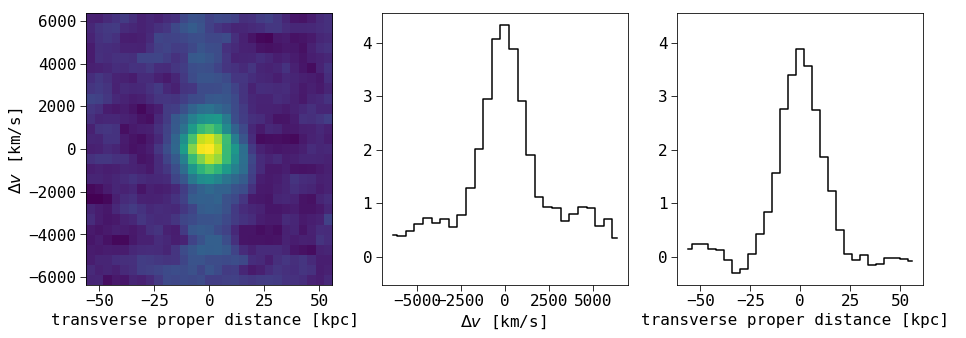

In [879]:
f = plt.figure(figsize=[15,5])
plt.subplot(1,3,1)

cent  = int(mstack.shape[1]/2. -.5)
cent  = int(mstack.shape[1]/2. -.5)

im = np.sum( mstack[:,cent-1:cent+2,:], axis=1)

extent = [ np.min( xxnew) , np.max( xxnew) , np.min(zznew), np.max(zznew) ] 
plt.imshow( im, extent=extent, aspect='auto')
plt.xlabel("x [\"]")

if REDSHIFTSPACE:
    plt.ylabel("$\Delta v$ [km/s] ")
else:
    plt.ylabel("$\Delta zpix$ [px] ")

if TRANSVERSEDISTANCE:
    plt.xlabel("transverse proper distance [kpc] ")
else:
    plt.xlabel("$\Delta x$ [px] ")
  
ax2 = plt.subplot(1,3,2)
xticks = np.linspace( np.min(zznew), np.max(zznew) ,len(im[:,cent]) )
plt.plot(xticks, im[:,cent], drawstyle="steps-mid" )
if REDSHIFTSPACE:
    plt.xlabel("$\Delta v$ [km/s] ")
    plt.xticks([-5000., -2500., 0., 2500., 5000.,])
    
else:
    plt.xlabel("$\Delta zpix$ [px] ")

ax3 = plt.subplot(1,3,3,  sharey = ax2)
xticks = np.linspace( np.min(xxnew), np.max(xxnew) ,len(im[cent, :]) )
plt.plot(xticks,  im[cent, :], drawstyle="steps-mid")
if TRANSVERSEDISTANCE:
    plt.xlabel("transverse proper distance [kpc] ")
else:

    plt.xlabel("$\Delta x$ [px] ")

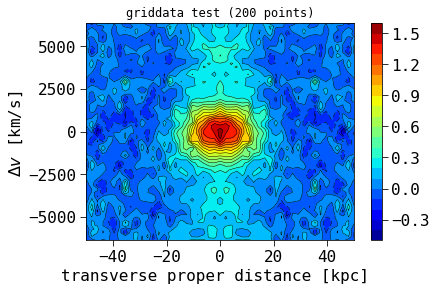

In [896]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
# make up some randomly distributed data

x = D.flatten()
z = Z.flatten()
# define grid.
xi = np.linspace(0, 50.,25)
zi = np.linspace(np.min(zznew), np.max(zznew),60)

d = mstack.flatten()
di = griddata((x, z), d, (xi[None,:], zi[:,None]), method='cubic')
# contour the gridded data, plotting dots at the randomly spaced data points.


N = 20

# mirror data about y
axi = np.hstack([ - xi[::-1], xi ])
adi = np.hstack([di[:, ::-1],di])


CS = plt.contour(axi,zi,adi,N,linewidths=0.5,colors='k')
CS = plt.contourf(axi,zi,adi,N,cmap=plt.cm.jet)

plt.colorbar() # draw colorbar
plt.title('griddata test (%d points)' % npts)



#CS = plt.contour(xi,zi,di,15,linewidths=0.5,colors='k')
#CS = plt.contourf(xi,zi,di,15,cmap=plt.cm.jet)


if REDSHIFTSPACE:
    plt.ylabel("$\Delta v$ [km/s] ")
else:
    plt.ylabel("$\Delta zpix$ [px] ")

if TRANSVERSEDISTANCE:
    plt.xlabel("transverse proper distance [kpc] ")
else:
    plt.xlabel("$\Delta x$ [px] ")

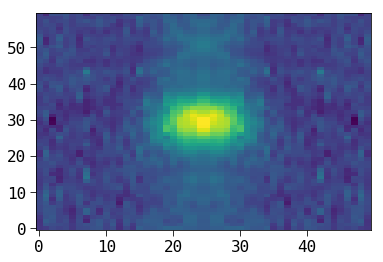

In [897]:
plt.imshow(adi,origin="bottom", aspect="auto")

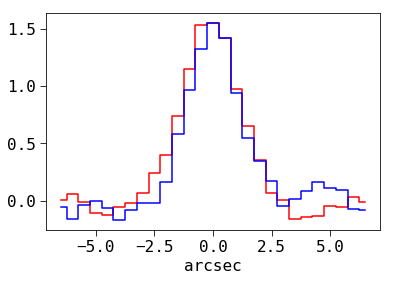

In [450]:
#plt.plot( mstack, drawstyle="steps-mid" , c = "k")
xx = np.arange(mstack.shape[1])*.5
xx = xx - np.max(xx)/2.

plt.plot(xx, mstack[zsize_new//2][13,:], drawstyle="steps-mid" , c = "r")
plt.plot(xx, mstack[zsize_new//2][:,13], drawstyle="steps-mid" , c = "b")
plt.xlabel("arcsec")



In [422]:
# what follows is code to save which objects should be used for stacking

In [401]:
from astropy.table import Column

In [402]:
cat.add_column(Column(name="use_stack", description="Use for pointsource stacking.", \
                      dtype=bool, data=[False]*len(cat)))

In [405]:
from IPython.html import widgets
from ipywidgets import Layout
from IPython.display import display,clear_output

#cb_use = {}
count = 0
for cb in cb_use:
    ifu,id = cb
    #print("ifu:{} id:{} {}".format(ifu, id, cb_use[cb].value))
    ii = (cat["ifu"] == ifu) * (cat["id"] == id)
    if sum(ii) == 1:
        cat["use_stack"][ii] = cb_use[cb].value
        count += cb_use[cb].value
    elif sum(ii) > 1:
        print("Error: Could not identify source for IFU {} with id {}.".format(ifu, id))
    
print(count)   

119


In [408]:
cat.write("../data/mmsf2outcube_COSMOSC_allifu.cat", format="ascii.ecsv")

In [333]:
zsize_new//2

0

array([-7.5, -7. , -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. , -2.5,
       -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5])